<h2 align=center> Facial Expression Recognition</h2>

## Importing Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os

%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.12.0


In [3]:
base_path = r"C:\Users\user\Desktop\machine learning\Facial Expression-cum-Music Recommender\train"
for expression in os.listdir(base_path):
    expression_path = os.path.join(base_path, expression)
    if os.path.isdir(expression_path):
        num_files = len(os.listdir(expression_path))
        print(f"{num_files} {expression} images")

3995 angry images
436 disgust images
4097 fear images
7215 happy images
4965 neutral images
4830 sad images
3171 surprise images


## Generate Training and Validation Batches

In [4]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_directory = r"C:\Users\user\Desktop\machine learning\Facial Expression-cum-Music Recommender\train"
test_directory = r"C:\Users\user\Desktop\machine learning\Facial Expression-cum-Music Recommender\test"


train_generator = datagen_train.flow_from_directory(train_directory,
                                                    target_size=(img_size, img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)
datagen_validation = ImageDataGenerator(horizontal_flip=True)

validation_generator = datagen_validation.flow_from_directory(test_directory,
                                                              target_size=(img_size, img_size),
                                                              color_mode="grayscale",
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

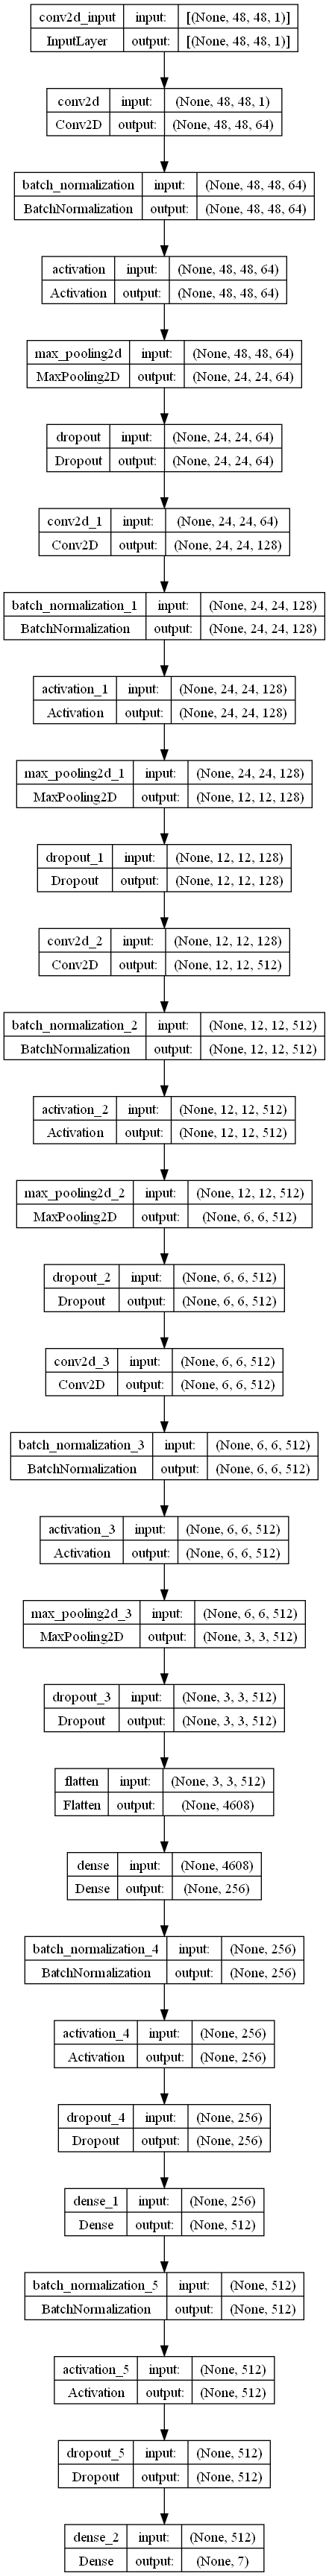

In [6]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=200)

In [8]:
# %%time

# epochs = 15
# steps_per_epoch = train_generator.n//train_generator.batch_size
# validation_steps = validation_generator.n//validation_generator.batch_size

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=2, min_lr=0.00001, mode='auto')
# checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
#                              save_weights_only=True, mode='max', verbose=1)
# callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

# history = model.fit(
#     x=train_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=epochs,
#     validation_data = validation_generator,
#     validation_steps = validation_steps,
#     callbacks=callbacks
# )

In [9]:
# model_json = model.to_json()
# model.save_weights('model_weights.h5')
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)

In [7]:
from tensorflow.keras.models import model_from_json
import numpy as np

import tensorflow as tf


class FacialExpressionModel(object):

    EMOTIONS_LIST = ["Angry", "Disgust",
                    "Fear", "Happy",
                    "Neutral", "Sad",
                    "Surprise"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()

    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]

In [8]:
from keras.models import model_from_json  
import cv2

facec = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
model = FacialExpressionModel("model.json", "model_weights.h5")
font = cv2.FONT_HERSHEY_SIMPLEX
detected_emotions = []

class VideoCamera(object):
    def __init__(self):
        self.video = cv2.VideoCapture(0)

    def __del__(self):
        self.video.release()

    # returns camera frames along with bounding boxes and predictions
    def get_frame(self):
        _, fr = self.video.read()
        gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        faces = facec.detectMultiScale(gray_fr, 1.3, 5)

        for (x, y, w, h) in faces:
            fc = gray_fr[y:y+h, x:x+w]

            roi = cv2.resize(fc, (48, 48))
            pred = model.predict_emotion(roi[np.newaxis, :, :, np.newaxis])
            detected_emotions.append(pred)

            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)

        return fr

In [9]:
import time
def gen(camera):
    start_time=time.time()

    while time.time() - start_time<10 :
        frame = camera.get_frame()
        cv2.imshow('Facial Expression Recognization',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    print(detected_emotions)
        
    cv2.destroyAllWindows()
def process_detected_emotions(detected_emotions):
    # Remove "neutral" from the list of detected emotions.
    filtered_emotions = [emotion for emotion in detected_emotions if emotion != "Neutral"]

    if filtered_emotions:
        # Count the occurrences of each emotion.
        emotion_counts = {emotion: filtered_emotions.count(emotion) for emotion in set(filtered_emotions)}

        # Find the emotion with the maximum count.
        max_emotion = max(emotion_counts, key=emotion_counts.get)

        return max_emotion
    else:
        return None

In [10]:
import cv2

gen(VideoCamera())
    
max_emotion = process_detected_emotions(detected_emotions)
if max_emotion:
    print("Maximum emotion (excluding 'Neutral'): ", max_emotion)
else:
    print("No emotions detected (excluding 'Neutral').")
import webbrowser
if max_emotion:
    print("Maximum emotion (excluding 'Neutral'): ", max_emotion)
    
    # Define the YouTube playlist URLs based on emotions
    playlists = {
        'Happy': 'https://www.youtube.com/watch?v=JGwWNGJdvx8&list=PLAQ7nLSEnhWTEihjeM1I-ToPDJEKfZHZu',
        'Sad': 'https://www.youtube.com/watch?v=CveANi17YfU&list=PL3-sRm8xAzY-w9GS19pLXMyFRTuJcuUjy',
        'Angry': 'https://www.youtube.com/watch?v=Vrr3lRLjZ1Y&list=PLknqyEOvGo1YgL11BN1m-YOxaFHl29elY',
    
        
        # Add more emotions and corresponding playlist URLs
    }

    # Check if the detected emotion has a corresponding playlist
    if max_emotion in playlists:
        playlist_url = playlists[max_emotion]
        webbrowser.open(playlist_url)
        print("Opening playlist for", max_emotion, "emotion.")
    else:
        print("No playlist available for", max_emotion, "emotion.")
else:
    print("No emotions detected (excluding 'Neutral').")

1/1 [==============================] - 0s 35ms/step
['Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy']
Maximum emotion (excluding 'Neutral'):  Happy
Maximum emotion (excluding 'Neutral'):  Happy
Opening playlist for Happy emotion.
